In [38]:
import pickle
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score,precision_recall_curve,f1_score, fbeta_score,accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import re
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import shap
from imblearn.pipeline import Pipeline, make_pipeline
import joblib





In [ ]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.precision", 4)

# Clean data for model developing

In [44]:
final_df = pickle.load(open('final_df.p', 'rb'))


FileNotFoundError: [Errno 2] No such file or directory: 'final_df.p'

In [ ]:
# there is huge class imbalance 
final_df.target.value_counts()

In [ ]:
# drop unnecessary columns
final_df.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 'country_code', 'permalink', 'name', 'status'], inplace=True)


In [ ]:
# change the target variable to binary
final_df['target'] = final_df['target'].astype('int64')


In [ ]:
# need to label encode categorical variables
categorical_feature_mask = final_df.dtypes==object
categorical_cols = final_df.columns[categorical_feature_mask].tolist()

le = LabelEncoder()

final_df['category_list'] = final_df[['category_list']].apply(le.fit_transform)
category_dict = dict(zip(le.classes_, le.transform(le.classes_)))
category_dict = {k.capitalize():v for k,v in category_dict.items()}
final_df['state_code'] = final_df[['state_code']].apply(le.fit_transform)
state_dict = dict(zip(le.classes_, le.transform(le.classes_)))

In [ ]:
# store the values for flask app
roundA_dict = {'No':0, 'Yes':1, 'N/A':2}
roundB_dict = {'No':0, 'Yes':1, 'N/A':2}
roundC_dict = {'No':0, 'Yes':1, 'N/A':2}
roundD_dict = {'No':0, 'Yes':1, 'N/A':2}
investments_dict = {'0':0, '1':1, '2':2, '3':3, 'More than 3':4, 'N/A':5}
top500_dict = {'0':0, '1':1, '2':2, '3':3, 'More than 3':4, 'N/A':5}
vc_dict = {'No':0, 'Yes':1, 'N/A':2}
rounds_dict = {'0':0, '1':1, '2':2, '3':3, 'More than 3':4}

Encoded_dicts = []
Encoded_dicts.append(category_dict)
Encoded_dicts.append(state_dict)
Encoded_dicts.append(roundA_dict)
Encoded_dicts.append(roundB_dict)
Encoded_dicts.append(roundC_dict)
Encoded_dicts.append(roundD_dict)
Encoded_dicts.append(investments_dict)
Encoded_dicts.append(top500_dict)
Encoded_dicts.append(vc_dict)
Encoded_dicts.append(rounds_dict)

with open('Encoded_dicts.pk1', 'wb') as f:
    pickle.dump(Encoded_dicts, f)



In [ ]:
# one hot encode the labels
ohe = OneHotEncoder(handle_unknown='ignore')

X_cat = ohe.fit_transform(final_df[categorical_cols]).toarray()
X_cat_df = pd.DataFrame(X_cat, columns = ohe.get_feature_names(categorical_cols))


In [ ]:
# add onehot encoded columns to df
final_df = final_df.reset_index().drop('index', axis=1)
final_df = pd.concat([final_df, X_cat_df], axis=1)

In [ ]:
# split the data into train and test
X = final_df.drop(columns=['target', 'category_list', 'state_code'])
y = final_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=53)

# Initial model comparison

In [34]:
def make_heatmap(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 8))
    conf_matrix = confusion_matrix(y_test, y_pred, normalize="all")
    sns.heatmap((conf_matrix*100), annot=True, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("{} Confusion Matrix".format(model_name));

In [1200]:
# store various models for comparison
models = []
models.append(('KNN',KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('SVM', LinearSVC()))
models.append(('Random Forest', RandomForestClassifier(n_estimators=50)))

In [1201]:
# store the accuracy scores
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)


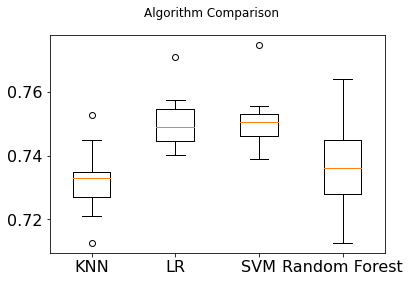

In [1202]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Explore which oversampling/undersampling method to use

## The dataset is very imbalanced so need to decide on which sampling method to use to tackle this problem

In [1203]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, np.array(y_train).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_train, y_train))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.7584697373429767
Test set:  0.7571483771251932
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3760
           1       0.58      0.40      0.47      1416

    accuracy                           0.76      5176
   macro avg       0.69      0.65      0.66      5176
weighted avg       0.74      0.76      0.74      5176



In [1204]:
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)
log_reg.fit(X_smote, np.array(y_smote).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_smote, y_smote))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.7964758286388052
Test set:  0.7440108191653787
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      3760
           1       0.54      0.49      0.51      1416

    accuracy                           0.74      5176
   macro avg       0.67      0.66      0.67      5176
weighted avg       0.74      0.74      0.74      5176



In [1205]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy="minority").fit_sample(X_train, y_train)
log_reg.fit(X_adasyn, np.array(y_adasyn).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_adasyn, y_adasyn))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.7905463151666557
Test set:  0.7449768160741885
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      3760
           1       0.54      0.49      0.51      1416

    accuracy                           0.74      5176
   macro avg       0.68      0.67      0.67      5176
weighted avg       0.74      0.74      0.74      5176



In [1206]:
X_nm, y_nm = NearMiss().fit_sample(X_train, y_train)
log_reg.fit(X_nm, np.array(y_nm).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_nm, y_nm))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.8486956521739131
Test set:  0.6595826893353941
              precision    recall  f1-score   support

           0       0.89      0.61      0.72      3760
           1       0.43      0.80      0.56      1416

    accuracy                           0.66      5176
   macro avg       0.66      0.70      0.64      5176
weighted avg       0.77      0.66      0.68      5176



### seems like SMOTE produces the best result with least overfitting issue

# Optimize logistic regression (Model of Choice)

In [ ]:
# create parameter grid for grid search
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [0.001,0.01,0.1,1,10,100]
grid = dict(solver=solvers,C=c_values)
new_grid = {'logisticregression__' + key: grid[key] for key in grid}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=62)

In [ ]:
# scale the data and prepare pipeline for SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_pipeline = make_pipeline(SMOTE(random_state=43), LogisticRegression())
cross_val_score(lr_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [ ]:
# grid search through parameters
grid_lr = GridSearchCV(lr_pipeline, param_grid=new_grid, cv=kf, n_jobs=-1, scoring='recall', error_score=0)
grid_lr.fit(X_train, y_train)

In [ ]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)

In [1211]:
# classification report 
y_test_predict = grid_lr.best_estimator_.named_steps['logisticregression'].predict(X_test)
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78      3760
           1       0.48      0.75      0.59      1416

    accuracy                           0.71      5176
   macro avg       0.68      0.72      0.68      5176
weighted avg       0.77      0.71      0.73      5176



## Look at which threshold would be best to use in terms of F_Beta Score

### Utilize F-beta score to optimize balance between recall and precision. Since I want to focus more on recall to capture as much successful companies out there I will be using beta value of 2 to weigh recall more heavily. 

In [ ]:
def threshold_tuning(X, y, model, threshold):

    # train-val split and oversample
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=.2, random_state=0)
    X_oversampled_train, y_oversampled_train = SMOTE(random_state=42).fit_sample(
        X_train, y_train)

    # instantiate One vs. Rest Classifier, which allows for use
   
    # fit model and predict probabilities of validation data being in each class
    #model.fit(X_oversampled_train, y_oversampled_train)
    fbeta_list = []

    for prob in threshold:
        fbeta_list.append(fbeta_score(y_val, model.predict_proba(X_val)[:, 1] > prob, 2))

    all_fbeta = list(zip(threshold, fbeta_list))
    best_fbeta = max(list(zip(threshold, fbeta_list)), key=lambda x: x[1])
    
    return all_fbeta, best_fbeta
    

In [ ]:
prob_threshold = np.arange(0, 1, 0.005)

all_fbeta_lr, best_fbeta_lr = threshold_tuning(X_train, y_train, grid_lr.best_estimator_.named_steps['logisticregression'], threshold=prob_threshold)

In [ ]:
# recall score on both train and test looks good
print(recall_score(y_train, grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_train)[:,1]>best_fbeta[0]))
print(recall_score(y_test, grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:,1]>best_fbeta[0]))

In [1215]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:, 1])

ROC AUC score =  0.788432353648275


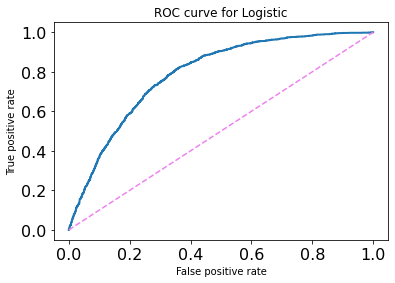

In [1216]:
# visualize ROC curve
plt.plot(fpr_lr, tpr_lr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic');
print("ROC AUC score = ", roc_auc_score(y_test, grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:, 1]))

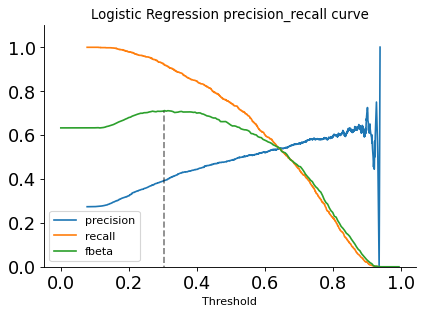

In [1217]:
# visualize the precision vs recall tradeoff
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_lr))[0],
         list(zip(*all_fbeta_lr))[1],
         label='fbeta')
plt.plot([best_fbeta_lr[0], best_fbeta_lr[0]], [-1, best_fbeta_lr[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_lr[0], best_fbeta_lr[1])
plt.ylim([0, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Logistic Regression precision_recall curve')
sns.despine()


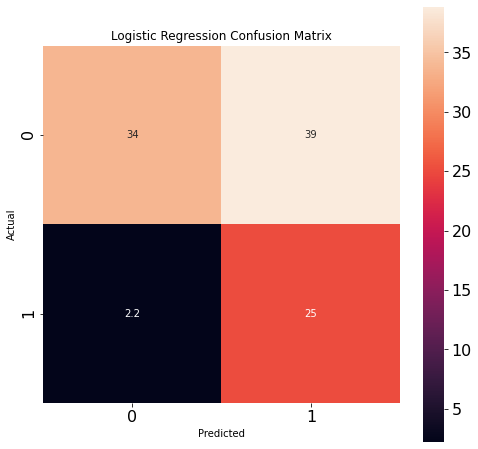

In [1218]:
# Reduce the percentage of FN but FP seems high
make_heatmap(y_test, grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:, 1]>best_fbeta_lr[0], 'Logistic Regression')

In [61]:
confusion_matrix(y_test, grid_lr.best_estimator_.named_steps['logisticregression'].predict_proba(X_test)[:, 1]>best_fbeta_lr[0])


array([[1920, 1840],
       [ 147, 1269]])

## Logistic Regression feature importance

In [964]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=53)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

log_reg = LogisticRegression(C=0.001, solver='liblinear')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='liblinear')

In [1098]:
lr_top_coefs = lr_top_coefs.sort_values(by='coef', ascending=False).head(25).sort_values(by='coef')
lr_top_coefs.iloc[pd.np.r_[1:2, 11:25]]

,Feature,coef
67,roundD_raised_amount(-inf-14608981],-0.0647
57,Clean Tech,-0.0460
56,roundD_age(-inf-3.5],-0.0455
55,Energy,-0.0439
54,num_investments(2.5-4.5],-0.0426
53,investment_per_round(1300000-6510833.5],-0.0421
8,Bio Tech,0.0419
7,Cloud Computing,0.0541
6,Software,0.0549
5,investment_per_round(6510833.5-inf],0.0718


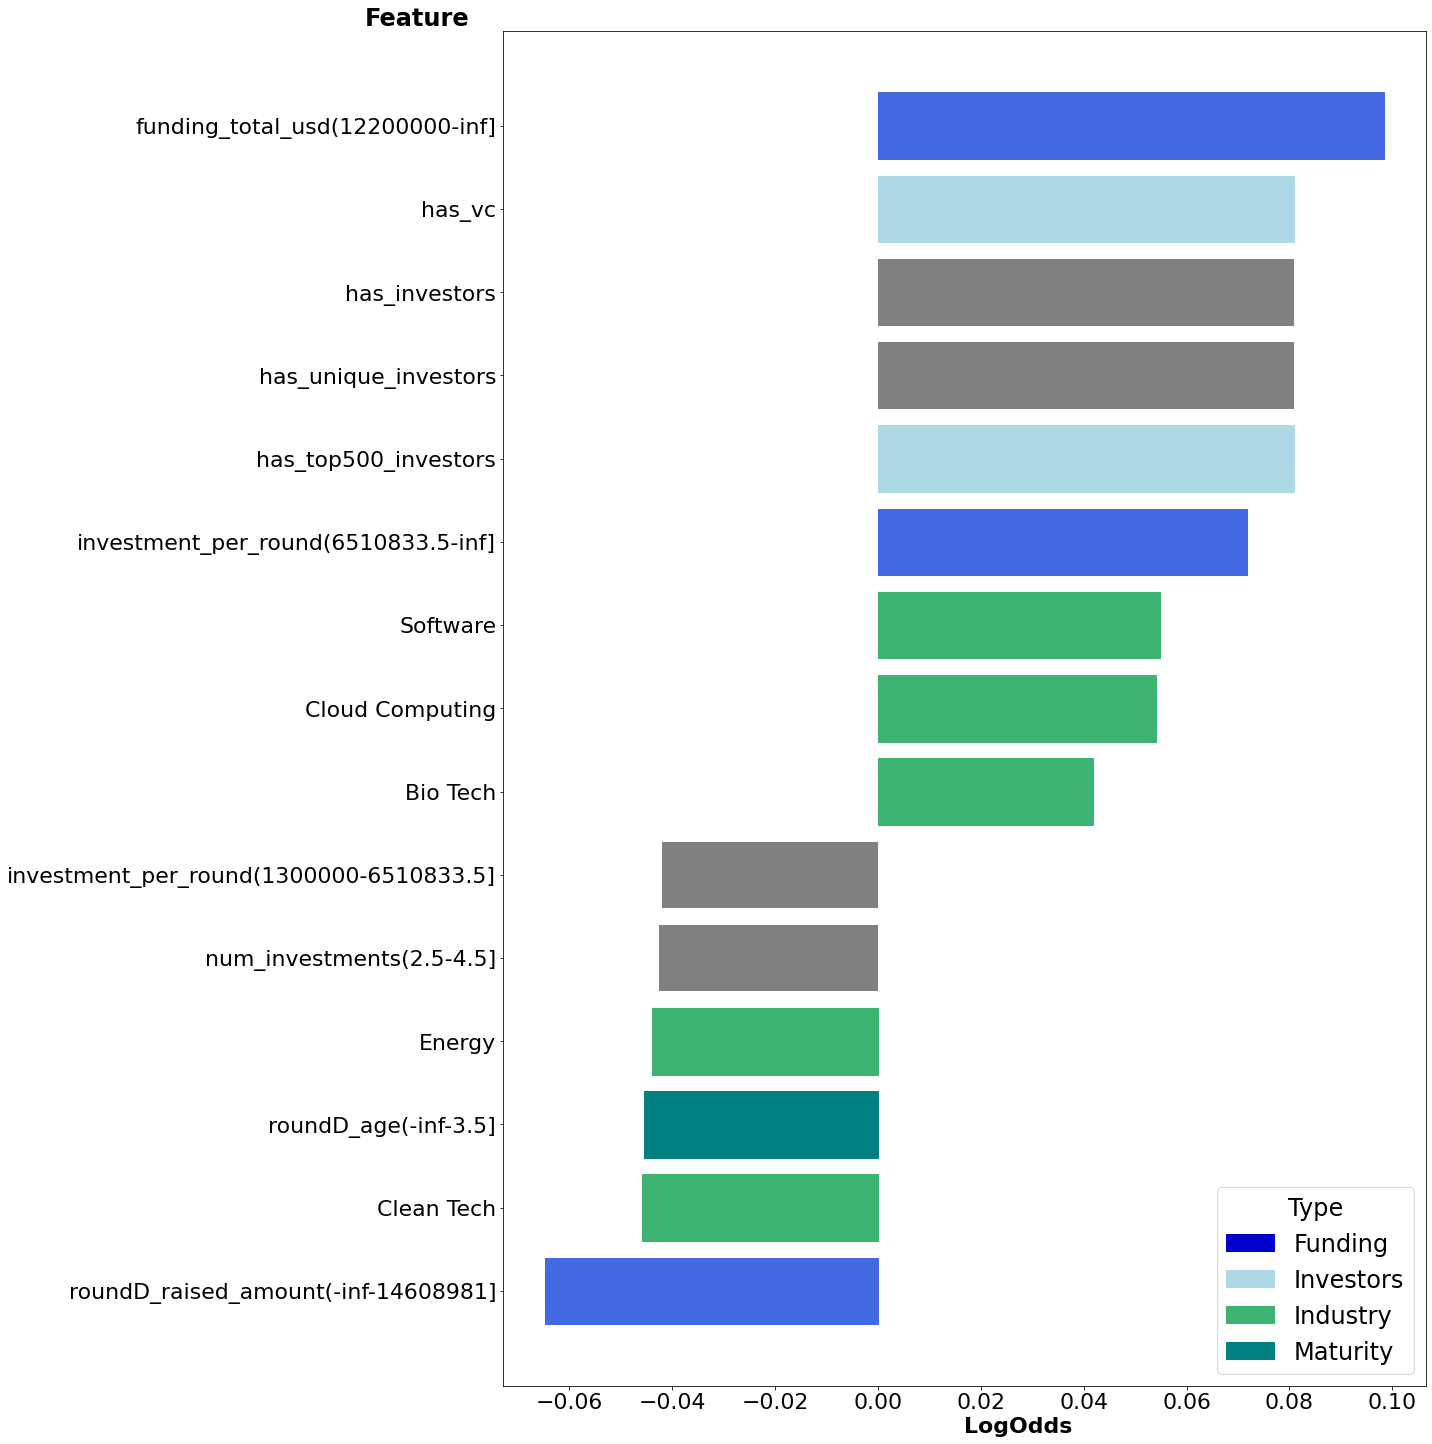

In [1118]:
#grid_lr_reg_coefs = 
import matplotlib.patches as mpatches

lr_reg_coefs = pd.DataFrame(sorted(list(zip(X.columns, log_reg.coef_[0])), key=(lambda x: x[1]), reverse=True), columns=['Feature', 'coef'])
lr_top_coefs = lr_reg_coefs[abs(lr_reg_coefs['coef'])>0.04]

lr_top_coefs = lr_top_coefs.sort_values(by='coef', ascending=False).head(25).sort_values(by='coef')
lr_top_coefs = lr_top_coefs.iloc[pd.np.r_[1:2, 11:25]]
lr_top_coefs.Feature[6] = 'Software'
lr_top_coefs.Feature[7] = 'Cloud Computing'
lr_top_coefs.Feature[8] = 'Bio Tech'
lr_top_coefs.Feature[55] = 'Energy'
lr_top_coefs.Feature[57] = 'Clean Tech'

fig, ax = plt.subplots(figsize=(20,20))
bars = plt.barh(lr_top_coefs['Feature'], lr_top_coefs['coef'], color='grey')
bars[14].set_color('royalblue')
bars[9].set_color('royalblue')
bars[0].set_color('royalblue')

bars[13].set_color('lightblue')
bars[10].set_color('lightblue')

bars[8].set_color('mediumseagreen')
bars[7].set_color('mediumseagreen')
bars[6].set_color('mediumseagreen')
bars[3].set_color('mediumseagreen')
bars[1].set_color('mediumseagreen')

bars[2].set_color('teal')

plt.ylabel('Feature', horizontalalignment='left', rotation=0, fontsize=24,fontweight='bold' )
ax.yaxis.set_label_coords(-0.15,1)
plt.xlabel('LogOdds', fontsize=22, fontweight='bold', horizontalalignment='left')
#ax.xaxis.set_label_coords(0,-0.005)
ax.tick_params(labelsize=22)

 
plt.grid(b=False)
lightblue_patch = mpatches.Patch(color='lightblue', label='Investors')
blue_patch = mpatches.Patch(color='mediumblue', label='Funding')
green_patch = mpatches.Patch(color='mediumseagreen', label='Industry')
teal_patch = mpatches.Patch(color='teal', label='Maturity')


plt.legend(handles=[blue_patch,lightblue_patch, green_patch, teal_patch], loc ='lower right', fontsize=24, title='Type', title_fontsize=24)
plt.tight_layout()
plt.savefig('feature_logodds.png')

# LR for Flask

In [729]:
model_df = pickle.load(open('model_df.p', 'rb'))
model_df['target'] = model_df['target'].astype('int64')


In [731]:
# one hot encode categorical variables
categorical_feature_mask = model_df.dtypes==object
categorical_cols = model_df.columns[categorical_feature_mask].tolist()

le = LabelEncoder()
model_df['category_list'] = model_df[['category_list']].apply(le.fit_transform)
model_df['state_code'] = model_df[['state_code']].apply(le.fit_transform)

ohe = OneHotEncoder(drop='first')
X_cat = ohe.fit_transform(model_df[categorical_cols]).toarray()
X_cat_df = pd.DataFrame(X_cat, columns = ohe.get_feature_names(categorical_cols))

In [733]:
model_df = model_df.reset_index().drop('index', axis=1)
model_df = pd.concat([model_df, X_cat_df], axis=1)

In [734]:
# prepare train and test and scale
X_flask = model_df.drop(columns=['target', 'category_list', 'hasfunding', 'state_code'])
y_flask = model_df['target']
X_train_flask, X_test_flask, y_train_flask, y_test_flask = train_test_split(X_flask, y_flask, test_size=0.33, stratify=y_flask, random_state=14)

X_train_flask = scaler.fit_transform(X_train_flask)
X_test_flask = scaler.transform(X_test_flask)

In [735]:
# prepare parameter grid for grid search
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [0.001,0.01,0.1,1,10,100]
grid = dict(solver=solvers,C=c_values)
new_grid = {'logisticregression__' + key: grid[key] for key in grid}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

In [736]:
lr_pipeline = make_pipeline(SMOTE(random_state=55), LogisticRegression())

cross_val_score(lr_pipeline, X_train_flask, y_train_flask, scoring='recall', cv=kf)

array([0.48521739, 0.5373913 , 0.5426087 , 0.50956522, 0.54434783])

In [737]:
grid_lr_flask = GridSearchCV(lr_pipeline, param_grid=new_grid, cv=kf, n_jobs=-1, scoring='recall', error_score=0)
grid_lr_flask.fit(X_train_flask, y_train_flask)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=55)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'sag',
                                                        'saga']},
             scoring='recall')

In [738]:
print(grid_lr_flask.best_params_)
print(grid_lr_flask.best_score_)

{'logisticregression__C': 0.01, 'logisticregression__solver': 'liblinear'}
0.7046956521739131


In [739]:
prob_threshold = np.arange(0, 1, 0.005)

all_fbeta, best_fbeta = threshold_tuning(X_train_flask, y_train_flask, grid_lr_flask.best_estimator_.named_steps['logisticregression'], threshold=prob_threshold)

In [740]:
# train and test recall score 
# no overfitting issue
print(recall_score(y_train_flask, grid_lr_flask.best_estimator_.named_steps['logisticregression'].predict_proba(X_train_flask)[:,1]>best_fbeta[0]))
print(recall_score(y_test_flask, grid_lr_flask.best_estimator_.named_steps['logisticregression'].predict_proba(X_test_flask)[:,1]>best_fbeta[0]))

0.9071304347826087

In [531]:
# save the model for flask app
pickle.dump(grid_lr_flask.best_estimator_, open('log_model.p', 'wb'))

In [532]:
# save one row of df for flask use
flask_df = X_flask.iloc[[1]]
flask_df = flask_df.reset_index(drop='index')
flask_df.loc[:,:] = 0

pickle.dump(flask_df, open('flask_df.pk1', 'wb'))

# Random Forest


In [1219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=56)
rf_pipeline = make_pipeline(SMOTE(random_state=45), 
                              RandomForestClassifier(n_estimators=100, random_state=45))

In [1220]:
n_estimators = [50, 100, 200]
max_depth = [4, 6, 10, 12]
random_state= [23]
grid = dict(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
new_grid = {'randomforestclassifier__' + key: grid[key] for key in grid}

In [1221]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
grid_rf = GridSearchCV(rf_pipeline, param_grid=new_grid, cv=kf, scoring='recall', return_train_score=True)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=45)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=45))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [23]},
             return_train_score=True, scoring='recall')

In [1222]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 23}
0.7492173913043478


In [1223]:
y_test_predict = grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)
recall_score(y_test, y_test_predict)

0.7740112994350282

In [1224]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test,
    grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)[:, 1])

ROC AUC score =  0.8036133399447049


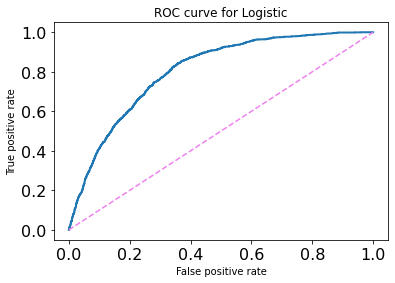

In [1225]:
# visualize ROC curve
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic');
print("ROC AUC score = ", roc_auc_score(y_test, grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)[:, 1]))

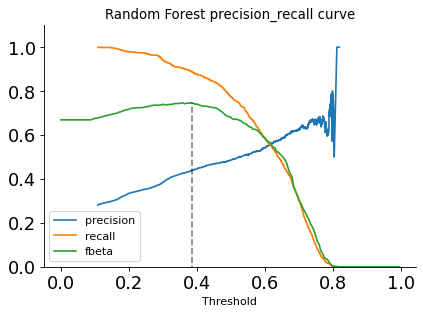

In [1226]:
# visualize the precision vs recall tradeoff
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_rf))[0],
         list(zip(*all_fbeta_rf))[1],
         label='fbeta')
plt.plot([best_fbeta_rf[0], best_fbeta_rf[0]], [-1, best_fbeta_rf[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_rf[0], best_fbeta_rf[1])
plt.ylim([0, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Random Forest precision_recall curve')
sns.despine()


In [1227]:
# threshold tuning
prob_threshold = np.arange(0, 1, 0.005)

all_fbeta_rf, best_fbeta_rf = threshold_tuning(X_train, y_train, grid_rf.best_estimator_.named_steps['randomforestclassifier'], threshold=prob_threshold)

In [1228]:
# slight issue as test score is higher
print(recall_score(y_train, grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_train)[:,1]>best_fbeta_rf[0]))
print(recall_score(y_test, grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)[:,1]>best_fbeta_rf[0]))

0.8942608695652174
0.9011299435028248


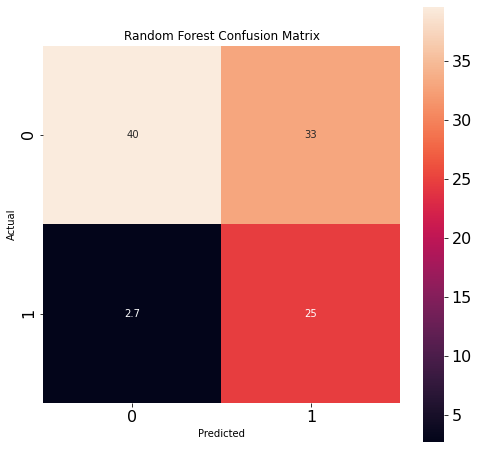

In [1229]:
# visualize the confusion matrix
make_heatmap(y_test, grid_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)[:,1]>best_fbeta_rf[0], 'Random Forest')

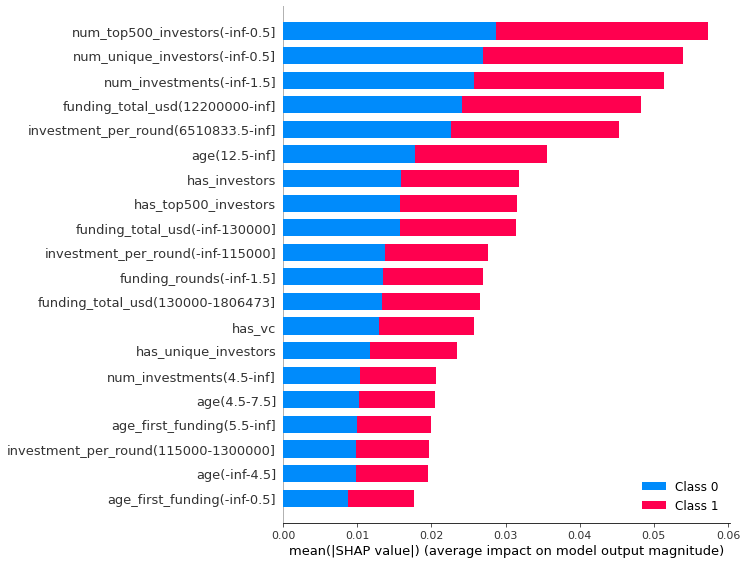

In [1230]:
# visualize feature importance
rf = RandomForestClassifier(n_estimators=200, max_depth=6)
sm = SMOTE()
X_train_rf, y_train_rf = sm.fit_sample(X_train, y_train)
rf.fit(X_train_rf, y_train_rf)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# XGBoost

In [13]:
# prepare data for xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

X_train_res, X_val, y_train_res, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

## Parameter tuning

### XGB max_depth tune

In [157]:
model = xgb.XGBClassifier()
maxdepth = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
param_grid = dict(max_depth=maxdepth)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=True)

In [158]:
grid_result = grid.fit(X_train_res, y_train_res)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
0.9336925049895208 {'max_depth': 5}


### XGB learning rate tune

In [161]:
model = xgb.XGBClassifier()
learningrate = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
param_grid = dict(learning_rate=learningrate)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=True)

In [162]:
grid_result = grid.fit(X_train_res, y_train_res)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
0.9326982083945182 {'learning_rate': 0.1}


### XGB subsample tune

In [163]:
model = xgb.XGBClassifier()
sub = [0.6, 0,7, 0.8, 0.9, 1]
param_grid = dict(subsample=sub)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=True)

In [164]:
grid_result = grid.fit(X_train_res, y_train_res)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.5s finished
0.9333882204118001 {'subsample': 0.9}


### XGB colsamples tune

In [165]:
model = xgb.XGBClassifier()
colsamples = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
param_grid = dict(colsample_bytree=colsamples)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=True)

In [166]:
grid_result = grid.fit(X_train_res, y_train_res)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.8s finished
0.9336848155506356 {'colsample_bytree': 0.7}


### XGB gamma tune

In [167]:
model = xgb.XGBClassifier()
gamma_value = [0, 0.5, 1, 2, 10]
param_grid = dict(gamma=gamma_value)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=True)

In [168]:
grid_result = grid.fit(X_train_res, y_train_res)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   35.8s finished
0.9341738801272348 {'gamma': 1}


## Fit model using best parameters


In [17]:
gbm = xgb.XGBClassifier( 
                       n_estimators=300000, #arbitrary large number
                       learning_rate=0.1,
                       max_depth=5,
                       subsample=0.9,
                       colsample_bytree=0.7,
                       gamma=1
                      )

eval_set=[(X_train_res,y_train_res),(X_val,y_val)] #tracking train/validation error as we go
gbm.fit( 
        X_train, y_train, 
        eval_set=eval_set,
        eval_metric='logloss',
        early_stopping_rounds=20,
        verbose=True #gives output log as below
        )

1-logloss:0.16024
[4809]	validation_0-logloss:0.15766	validation_1-logloss:0.16023
[4810]	validation_0-logloss:0.15766	validation_1-logloss:0.16023
[4811]	validation_0-logloss:0.15765	validation_1-logloss:0.16020
[4812]	validation_0-logloss:0.15765	validation_1-logloss:0.16020
[4813]	validation_0-logloss:0.15761	validation_1-logloss:0.16018
[4814]	validation_0-logloss:0.15760	validation_1-logloss:0.16017
[4815]	validation_0-logloss:0.15760	validation_1-logloss:0.16017
[4816]	validation_0-logloss:0.15760	validation_1-logloss:0.16017
[4817]	validation_0-logloss:0.15760	validation_1-logloss:0.16017
[4818]	validation_0-logloss:0.15759	validation_1-logloss:0.16018
[4819]	validation_0-logloss:0.15759	validation_1-logloss:0.16016
[4820]	validation_0-logloss:0.15757	validation_1-logloss:0.16014
[4821]	validation_0-logloss:0.15757	validation_1-logloss:0.16014
[4822]	validation_0-logloss:0.15756	validation_1-logloss:0.16015
[4823]	validation_0-logloss:0.15755	validation_1-logloss:0.16013
[4824]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300000, n_jobs=0, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [18]:
recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))


0.4569209039548023

In [19]:
fpr_xg, tpr_xg, thresholds_xg = roc_curve(
    y_test,
    gbm.predict_proba(X_test)[:, 1])

ROC AUC score =  0.7555888628440919


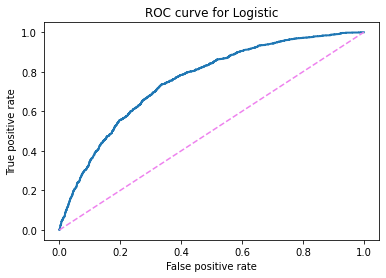

In [20]:
# visualize ROC curve
plt.plot(fpr_xg, tpr_xg,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic');
print("ROC AUC score = ", roc_auc_score(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:,1]))

In [23]:
prob_threshold = np.arange(0, 1, 0.1)

all_fbeta_xg, best_fbeta_xg = threshold_tuning(X_train, y_train, gbm, threshold=prob_threshold)

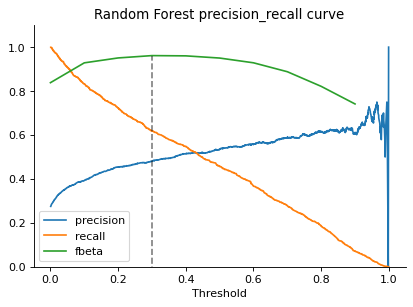

In [24]:
# visualize the precision vs recall tradeoff
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_xg))[0],
         list(zip(*all_fbeta_xg))[1],
         label='fbeta')
plt.plot([best_fbeta_xg[0], best_fbeta_xg[0]], [-1, best_fbeta_xg[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_xg[0], best_fbeta_xg[1])
plt.ylim([0, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Random Forest precision_recall curve')
sns.despine()


In [32]:
print(recall_score(y_train, gbm.predict_proba(X_train, ntree_limit=gbm.best_ntree_limit)[:,1]>best_fbeta_xg[0]))
print(recall_score(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:,1]>best_fbeta_xg[0]))

0.972880911830211
0.6179378531073446


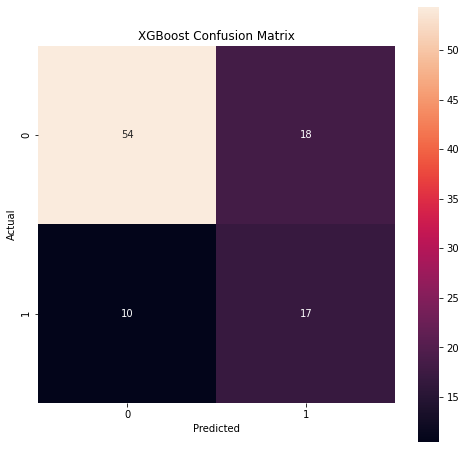

In [36]:
# visualize the confusion matrix
make_heatmap(y_test, gbm.predict_proba(X_test, ntree_limit=gbm.best_ntree_limit)[:,1]>best_fbeta_xg[0], 'XGBoost')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

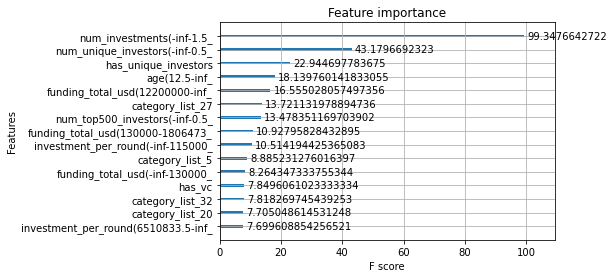

In [811]:
xgb.plot_importance(gbm, max_num_features=15, importance_type='gain')

In [837]:
explainer = shap.TreeExplainer(xgb_tune)
shap_values = explainer.shap_values(X_test)

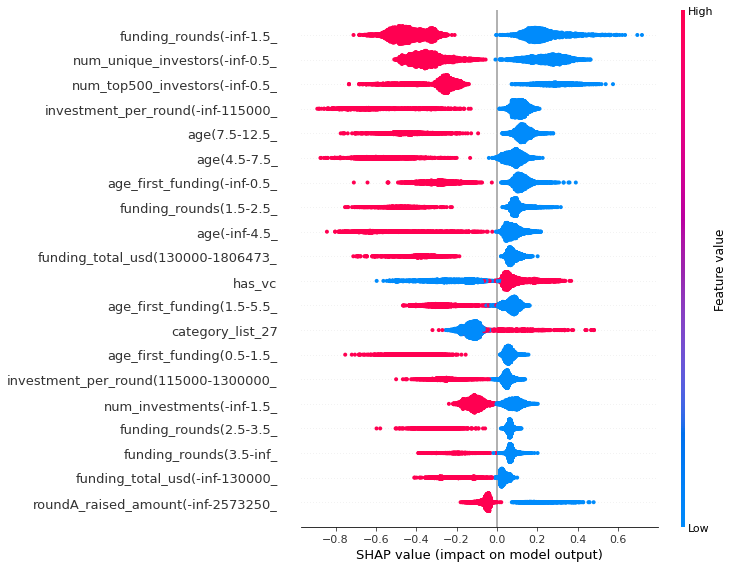

In [839]:
shap.summary_plot(shap_values, X_test)
